### <center> **Análise Preditiva:** gênero

**Objetivo:** Preve o gênero que será mais ouvido ao final do ano baseado no histórico do usuário

In [87]:
# Importações
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [59]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('spotify_songs_sofia.csv')

### Compreensão dos Dados

In [60]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25997 entries, 0 to 25996
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 25997 non-null  object 
 1   platform                           25997 non-null  object 
 2   ms_played                          25997 non-null  int64  
 3   conn_country                       25997 non-null  object 
 4   ip_addr                            25997 non-null  object 
 5   master_metadata_track_name         25997 non-null  object 
 6   master_metadata_album_artist_name  25997 non-null  object 
 7   master_metadata_album_album_name   25965 non-null  object 
 8   spotify_track_uri                  25997 non-null  object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      flo

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2023-04-04 18:25:30+00:00,android,11451,BR,177.76.148.44,Talk that Talk,TWICE,BETWEEN 1&2,spotify:track:0RDqNCRBGrSegk16Avfzuq,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632717,False,k-pop
1,2023-04-04 18:25:47+00:00,android,16559,BR,177.76.148.44,There's Nothing Holdin' Me Back,Shawn Mendes,Illuminate,spotify:track:7JJmb5XwzOO8jgpou264Ml,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632730,False,pop
2,2023-04-04 18:25:55+00:00,android,4168,BR,177.76.148.44,Woman,Doja Cat,Planet Her,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632747,False,pop
3,2023-04-04 19:23:17+00:00,android,80840,BR,177.76.148.44,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,clickrow,logout,False,False,False,1680635513,False,k-pop
4,2023-04-04 22:51:39+00:00,android,67760,BR,201.42.207.140,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,appload,logout,False,False,False,1680647986,False,k-pop


### Preparação dos Dados

In [62]:
# COlunas necessárias: ts, ms_played, shuffle, skipped, genero

# Copiando os dados para outro df
df_genre = df.copy()

# Excluindo colunas desnecessárias
df_genre = df_genre.drop(columns=['platform', 'master_metadata_album_artist_name', 'conn_country', 'ip_addr', 'master_metadata_track_name', 'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name', 'episode_show_name', 'spotify_episode_uri', 'audiobook_uri', 'audiobook_title', 'audiobook_chapter_uri', 'audiobook_chapter_title', 'reason_start', 'reason_end', 'offline', 'offline_timestamp', 'incognito_mode'])

# df limpo
display(df_genre.head())

,ts,ms_played,shuffle,skipped,genero
0,2023-04-04 18:25:30+00:00,11451,False,True,k-pop
1,2023-04-04 18:25:47+00:00,16559,False,True,pop
2,2023-04-04 18:25:55+00:00,4168,False,True,pop
3,2023-04-04 19:23:17+00:00,80840,False,False,k-pop
4,2023-04-04 22:51:39+00:00,67760,False,False,k-pop


In [63]:
# apagando músicas que foram puladas e estavam no modo aleatório
df_genre.drop(
    df_genre[(df_genre['shuffle'] == True) & (df_genre['skipped'] == True)].index, 
    inplace=True)

display(df_genre.head())

,ts,ms_played,shuffle,skipped,genero
0,2023-04-04 18:25:30+00:00,11451,False,True,k-pop
1,2023-04-04 18:25:47+00:00,16559,False,True,pop
2,2023-04-04 18:25:55+00:00,4168,False,True,pop
3,2023-04-04 19:23:17+00:00,80840,False,False,k-pop
4,2023-04-04 22:51:39+00:00,67760,False,False,k-pop


In [73]:
# Convertendo para timestamp
df_genre['ts'] = pd.to_datetime(df['ts'])

# Cria colunas úteis
df_genre['ano'] = df_genre['ts'].dt.year
df_genre['mes'] = df_genre['ts'].dt.to_period('M')

# Convertendo ms_played para minutos
df_genre['min_played'] = df_genre['ms_played'] / 60000

display(df_genre)


C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_28096\1197933744.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_genre['mes'] = df_genre['ts'].dt.to_period('M')


,ts,ms_played,shuffle,skipped,genero,ano,mes,min_played
0,2023-04-04 18:25:30+00:00,11451,False,True,k-pop,2023,2023-04,0.190850
1,2023-04-04 18:25:47+00:00,16559,False,True,pop,2023,2023-04,0.275983
2,2023-04-04 18:25:55+00:00,4168,False,True,pop,2023,2023-04,0.069467
3,2023-04-04 19:23:17+00:00,80840,False,False,k-pop,2023,2023-04,1.347333
4,2023-04-04 22:51:39+00:00,67760,False,False,k-pop,2023,2023-04,1.129333
...,...,...,...,...,...,...,...,...
25992,2026-01-29 22:55:17+00:00,122973,False,True,brega funk,2026,2026-01,2.049550
25993,2026-01-29 22:55:20+00:00,2639,False,True,brazilian funk,2026,2026-01,0.043983
25994,2026-01-29 22:56:55+00:00,96005,False,False,phonk,2026,2026-01,1.600083
25995,2026-01-29 22:57:07+00:00,9907,False,True,brazilian funk,2026,2026-01,0.165117


In [66]:
# Agregação mensal por gênero
df_month = (
    df_genre.groupby(['mes', 'genero'])
      .agg(
          plays=('genero', 'count'),
          total_min=('min_played', 'sum')
      )
      .reset_index()
)

display(df_month)

,mes,genero,plays,total_min
0,2023-04,Hip-Hop,1,2.297917
1,2023-04,art pop,1,4.909550
2,2023-04,axé,6,13.079250
3,2023-04,dark r&b,1,2.137717
4,2023-04,gospel,7,16.145933
...,...,...,...,...
1164,2026-01,soft pop,8,13.162950
1165,2026-01,speedcore,1,2.218900
1166,2026-01,stutter house,1,0.391350
1167,2026-01,synthpop,2,5.142750


In [91]:
# Criando variável numérica de mês 
# df_month['mes_num'] = (df_month['mes'].dt.year - df_month['mes'].dt.year.min()) * 12 + df_month['mes'].dt.month

display(df_month)
#  droppar a coluna mes_num
# df_month = df_month.drop(columns=['mes_num'])

,mes,genero,plays,total_min
0,2023-04,Hip-Hop,1,2.297917
1,2023-04,art pop,1,4.909550
2,2023-04,axé,6,13.079250
3,2023-04,dark r&b,1,2.137717
4,2023-04,gospel,7,16.145933
...,...,...,...,...
1164,2026-01,soft pop,8,13.162950
1165,2026-01,speedcore,1,2.218900
1166,2026-01,stutter house,1,0.391350
1167,2026-01,synthpop,2,5.142750


# Teste

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

df_model = df_month.copy()

df_model['mes'] = pd.to_datetime(df_model['mes'].dt.to_timestamp())

df_model = df_model.sort_values('mes')

df_model['mes_ord'] = (
    (df_model['mes'].dt.year - df_model['mes'].dt.year.min()) * 12
    + df_model['mes'].dt.month
)

# One-hot encoding
df_model = pd.get_dummies(df_model, columns=['genero'], drop_first=True)

X = df_model.drop(columns=['total_min', 'mes'])
y = df_model['total_min']

In [116]:
display(df_model.head())

,mes,plays,total_min,mes_ord,genero_Absolute Bangers,genero_Better than Nicki Minaj,genero_Canadian,genero_Chill House,genero_Eurovision,genero_FNAF,...,genero_trap,genero_trap funk,genero_trap soul,genero_trip-hop,genero_tropical house,genero_turkish pop,genero_uk garage,genero_witch house,genero_yacht rock,genero_zouk
0,2023-04-01,1,2.297917,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,2023-04-01,1,2.991950,4,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
10,2023-04-01,34,92.129133,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,2023-04-01,3,6.774983,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,2023-04-01,19,51.685233,4,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [117]:
n_test = 3

X_train = X.iloc[:-n_test]
X_test = X.iloc[-n_test:]

y_train = y.iloc[:-n_test]
y_test = y.iloc[-n_test:]

In [118]:
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [119]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 17.09341362963003
RMSE: 27.27301769841375
R2: 0.9871583162778329


In [120]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importance.head(10))

                   feature  importance
0                    plays    0.972045
1                  mes_ord    0.009288
162           genero_phonk    0.005760
51    genero_brazilian pop    0.003231
129           genero_k-pop    0.002263
186             genero_rnb    0.002085
166             genero_pop    0.001600
48   genero_brazilian funk    0.000974
159          genero_pagode    0.000807
192       genero_sertanejo    0.000146


In [124]:
# Criando um DataFrame para comparar Real vs Previsto
df_resultados = pd.DataFrame({
    'Mes_Ordinal': X_test['mes_ord'],
    'Minutos_Reais': y_test.values,
    'Minutos_Previstos': y_pred.round(2),
    'Erro_Absoluto': np.abs(y_test.values - y_pred).round(2)
})

print("\n--- Comparação das Previsões ---")
print(df_resultados)


--- Comparação das Previsões ---
      Mes_Ordinal  Minutos_Reais  Minutos_Previstos  Erro_Absoluto
1114           37     512.142700             559.25          47.11
1112           37       0.475067               1.22           0.75
1168           37       2.740950               6.16           3.42


C:\Users\sofiasantana-ieg\AppData\Local\Temp\ipykernel_28096\4006374821.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(2), width=0.4, palette='viridis')


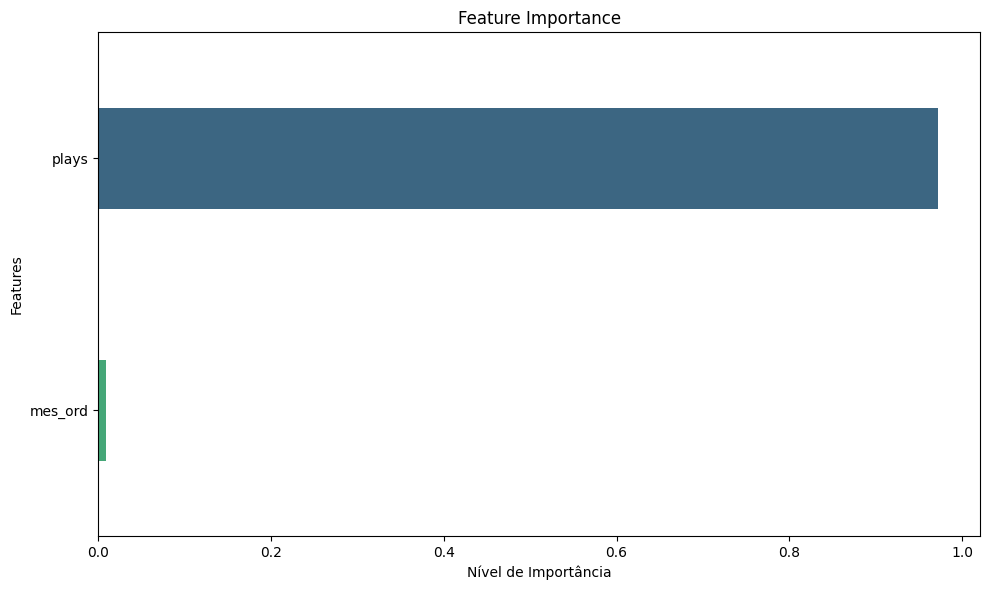

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo o tamanho da figura
plt.figure(figsize=(10, 6))

# Criando o gráfico de barras
sns.barplot(x='importance', y='feature', data=feature_importance.head(2), width=0.4, palette='viridis')

# Adicionando títulos e labels
plt.title('Feature Importance')
plt.xlabel('Nível de Importância')
plt.ylabel('Features')

# Ajustando o layout para não cortar os nomes
plt.tight_layout()

plt.show()